Understanding Mathematics Behinds Pairs Trading

Disclaimer: This tutorial is heavily inspired by the the tutorial series on Qunatopian:
Sources: https://www.quantopian.com/lectures/integration-cointegration-and-stationarity


In [73]:
from statsmodels.tsa.stattools import coint, adfuller
import numpy as np
import pandas as pd
import quandl

import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
# quandl.ApiConfig.api_key = "hMoDrEuVYRh79EhWU28o"

## Stationarity vs Non-Stationarity

A commonly untested assumption in time series analysis is the stationarity of the data. Data are stationary when the parameters of the data generating process do not change over time.

Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuation. 

<img src="Images/img1.jpg" style="width:600px; height: 300px;">
<img src="Images/img2.png" style="width:700px; height:400px;">
<img src = "Images/img3.png" style = "width:700px;height:400px;">

In [2]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)


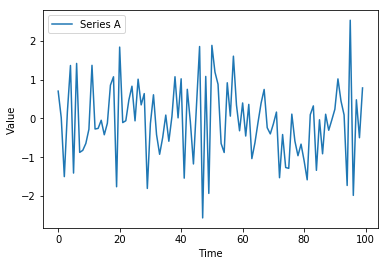

In [3]:
#Time Series A
#Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)

plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

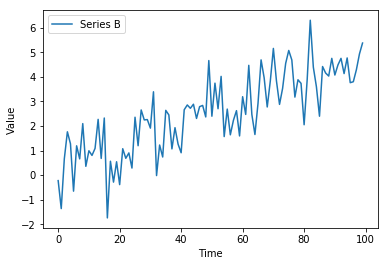

In [4]:
# Time Series B
#Set the parameters and the number of datapoints

T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.05, 1)
    B[t] = generate_datapoint(params)

plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B']);


# Why do we care about Stationarity? 

Many statistical tests, deep down in the fine print of their assumptions, require that the data being tested are stationary. Also, if you naively use certain statistics on a non-stationary data set, you will get garbage results. As an example, let's take an average through our non-stationary  B .

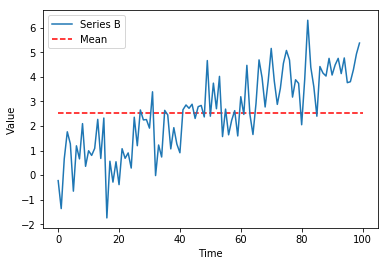

In [5]:
m = np.mean(B)

plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='r')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B', 'Mean']);

The computed mean will show the mean of all data points, but won't be useful for any forecasting of future state.

It's meaningless when compared with any specfic time, as it's a collection of different states at different times mashed together.

This is just a simple and clear example of why non-stationarity can screw with analysis, much more subtle problems can arise in practice.


# Testing for Stationarity


Now we want to check for stationarity using a statistical test.

In [6]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print ('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print ('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

In [7]:
check_for_stationarity(A);
check_for_stationarity(B);

p-value = 8.892165689758041e-25 The series A is likely stationary.
p-value = 0.7502645216890544 The series B is likely non-stationary.


The null hypothesis was that the time series is non-stationary. We set our cut off to 0.01. This means that if our p-value < cutoff, then we reject the null hypothesis. If it is greater than the cutoff, then we accept the null hypothesis.

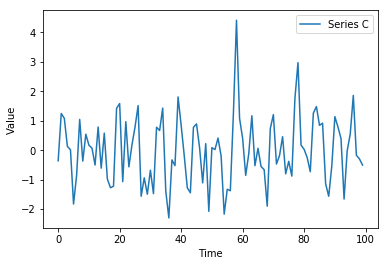

In [8]:
#  Set the number of datapoints
T = 100

C = pd.Series(index=range(T))
C.name = 'C'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (np.sin(t), 1)
    C[t] = generate_datapoint(params)

plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C']);

In [9]:
check_for_stationarity(C);

p-value = 1.6860721831572198e-13 The series C is likely stationary.


# Moving Average Representation/Wold's Theorem


This representation expresses any time series  Yt  as

$$ Y_t = \sum_{j=0}^\infty b_j \epsilon_{t-j} + \eta_t $$


$\epsilon$  is the 'innovation' series


$b_j$  are the moving average weights of the innovation series

η  is a deterministic series


The key here is as follows.  η  is deterministic, such as a sine wave. Therefore we could perfectly model it. The innovation process is stochastic and there to simulate new information occuring over time. Specifically, $\epsilon_t= \hat Y_t - Y_t$, where $Y_t$ is the optimal forecast of $Y_t$ using only information from time before $t$. In other words, the best prediction you can make at time $t-1$ cannot account for the randomness in $\epsilon$. 

Each $b_j$ just says how much previous values of $\epsilon$ influence $Y_t$.


# Back to Order of Integration


We will note integration order-i as  I(i) .

A time series is said to be  I(0)  if the following condition holds in a moving average representation. In hand-wavy english, the autocorrelation of the series decays sufficiently quickly.


$$\sum_{k=0}^\infty |b_k|^2 < \infty$$


This property turns out to be true of all stationary series, but by itself is not enough for stationarity to hold. This means that stationarity implies  I(0) , but  I(0)  does not imply stationarity. For more on orders of integration, please see the following links.

https://en.wikipedia.org/wiki/Order_of_integration 

# Testing for  I(0)

In practice testing whether the sum of the autocorrelations is finite may not be possible. It is possible in a mathematical derivation, but when we have a finite set of data and a finite number of estimated autocorrelations, the sum will always be finite. Given this difficulty, tests for  I(0)  rely on stationarity implying the property. If we find that a series is stationary, then it must also be  I(0) .

Let's take our original stationary series A. Because A is stationary, we know it's also  I(0) .



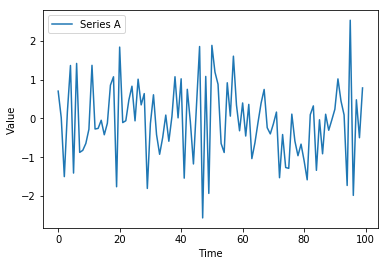

In [10]:
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

# Inductively Building Up Orders of Integration

If one takes an  I(0)  series and cumulatively sums it (discrete integration), the new series will be  I(1) . Notice how this is related to the calculus concept of integration. The same relation applies in general, to get  I(n)  take an  I(0)  series and iteratively take the cumulative sum  n  times.

Now let's make an  I(1)  series by taking the cumulative sum of A.



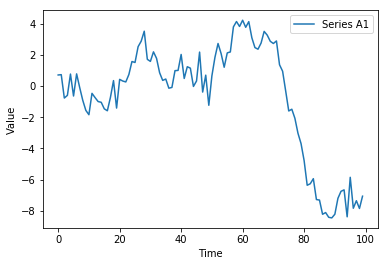

In [11]:

A1 = np.cumsum(A)

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1']);

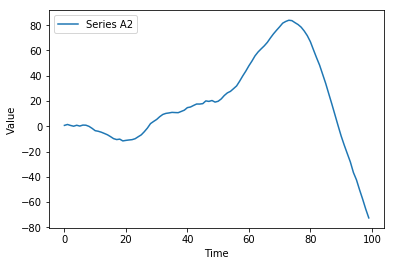

In [12]:
A2 = np.cumsum(A1)

plt.plot(A2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A2']);

In [13]:
check_for_stationarity(A2);

p-value = 0.01771741999300888 The series A is likely non-stationary.


# Breaking Down Orders of Integration

Conversely, to find the order of integration of a given series, we perform the inverse of a cumulative sum, which is the  Δ  or itemwise difference function. Specifically

$(1−L)X_t=X_t−X_t−1=ΔX$
 
$(1−L)^{d}X_t$

In this case  $L$  is the lag operator. Sometimes also written as  $B$  for 'backshift'.  $L$  fetches the second to last elements in a time series, and  $L_k$  fetches the k-th to last elements. So

$$LX_t=X_t−1$$
$$(1−L)X_t=X_t−X_t−1$$

A series  $Y_t$  is  I(1)  if the  $Y_t−Y_{t−1}$  is  I(0) . In other words, if you take an  I(0)  series and cumulatively sum it, you should get an  I(1)  series.

# Important Take-Away

Once all the math has settled, remember that any stationary series is  I(0).


# Real Data
Let's try this out on some real pricing data.





In [19]:
symbol_list = ['MSFT']
mydata = quandl.get('WIKI/MSFT', start_date="2014-01-01", end_date="2015-01-01")


In [34]:
X = mydata['Close']
check_for_stationarity(X);

p-value = 0.6657553928690043 The series Close is likely non-stationary.


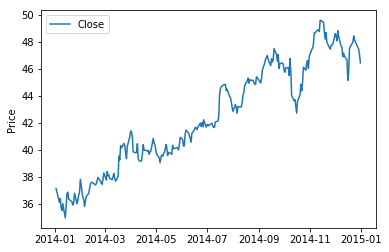

In [35]:
plt.plot(X.index, X.values)
plt.ylabel('Price')
plt.legend([X.name]);

p-value = 1.4094394098644581e-28 The series Close Additive Returns is likely stationary.


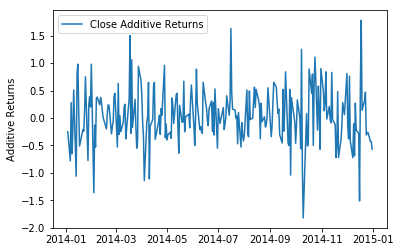

In [36]:
X1 = X.diff()[1:]
X1.name = X.name + ' Additive Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Additive Returns')
plt.legend([X1.name]);

p-value = 7.544648820539528e-29 The series Close Multiplicative Returns is likely stationary.


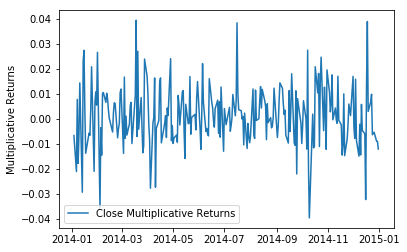

In [38]:
X1 = X.pct_change()[1:]
X1.name = X.name + ' Multiplicative Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Multiplicative Returns')
plt.legend([X1.name]);

Seems like the multiplicative returns are also stationary. Both the multiplicative and additive deltas on a series get at similar pieces of information, so it's not surprising both are stationary. In practice this might not always be the case.

# IMPORTANT NOTE

As always, you should not naively assume that because a time series is stationary in the past it will continue to be stationary in the future. Tests for consistency of stationarity such as cross validation and out of sample testing are necessary. This is true of any statistical property, we just reiterate it here. Returns may also go in and out of stationarity, and may be stationary or non-stationary depending on the timeframe and sampling frequency.

Note: Returns Analysis
The reason returns are usually used for modeling in quantitive finance is that they are far more stationary than prices. This makes them easier to model and returns forecasting more feasible. Forecasting prices is more difficult, as there are many trends induced by their  I(1)  integration. Even using a returns forecasting model to forecast price can be tricky, as any error in the returns forecast will be magnified over time.

# Cointegration
Finally, now that we've discussed stationarity and order of integration, we can discuss cointegration.


# Def: Linear Combination
A linear combination of the time series $( X_1 ,  X_2 ,  … ,  X_k )$ is a new time series, Y, constructed as follows for any set of real numbers  $b_1…b_k$ 
$Y=b_1X_1 + b_2X_2 +⋯+b_kX_k$
 
#  Formal Definition
The formal definition of cointegration is as follows.

For some set of time series $( X_1 ,  X_2 ,  … ,  X_k )$, if all series are  I(1) , and some linear combination of them is  I(0) , we say the set of time series is cointegrated.

# Example
$X_1 ,  X_2 , and  X_3$  are all  I(1) , and  $2X_1+X_2+0X_3=2X_1+X_2$  is  I(0) . In this case the time series are cointegrated.

# Intuition
The intuition here is that for some linear combination of the series, the result lacks much auto-covariance and is mostly noise. This is useful for cases such as pairs trading, in which we find two assets whose prices are cointegrated. Since the linear combination of their prices  $b_1A_1+b_2A_2$  is noise, we can bet on the relationship  $b_1A_1+b_2A_2$  mean reverting and place trades accordingly. 

See the Pairs Trading Lecture in the Quantopian Lecture Series for more information.

# Simulated Data Example
Let's make some data to demonstrate this.

In [173]:
# prices1 = quandl.get('WIKI/ABGB' , start_date='2014-01-01', end_date='2015-01-01')
prices2 = quandl.get('WIKI/JPM' , start_date='2014-01-01', end_date='2015-01-01')

In [174]:
prices2

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2014-01-02,58.31,58.5000,57.9745,58.21,15627600.0,0.38,1.0,52.852149,53.024365,52.548052,52.761509,15627600.0
2014-01-03,58.29,58.9500,58.2100,58.66,14214100.0,0.00,1.0,52.834021,53.432245,52.761509,53.169389,14214100.0
2014-01-06,59.16,59.4650,58.8300,59.00,17550700.0,0.00,1.0,53.622589,53.899041,53.323477,53.477565,17550700.0
2014-01-07,59.29,59.4300,58.1100,58.32,17851200.0,0.00,1.0,53.740421,53.867317,52.670869,52.861213,17851200.0
2014-01-08,58.54,58.9100,58.3000,58.87,14687400.0,0.00,1.0,53.060621,53.395989,52.843085,53.359733,14687400.0
2014-01-09,58.98,59.0000,58.3300,58.76,13242500.0,0.00,1.0,53.459437,53.477565,52.870277,53.260029,13242500.0
2014-01-10,58.67,58.7600,58.1750,58.49,12694900.0,0.00,1.0,53.178453,53.260029,52.729785,53.015301,12694900.0
2014-01-13,58.51,58.6700,57.5300,57.70,20711600.0,0.00,1.0,53.033429,53.178453,52.145158,52.299246,20711600.0
2014-01-14,58.30,58.5800,57.5600,57.74,30272400.0,0.00,1.0,52.843085,53.096877,52.172350,52.335502,30272400.0


In [175]:
prices3 = quandl.get('WIKI/GS' , start_date='2014-01-01', end_date='2015-01-01')

In [241]:
X1 = prices2["Close"]
X2 = prices3["Close"]

In [242]:
check_for_stationarity(X1);
check_for_stationarity(X2);

X_test_1 = X1.diff()[1:]
check_for_stationarity(X_test_1)


X_test_2 = X2.diff()[1:]
check_for_stationarity(X_test_2)

p-value = 0.1743666131569807 The series Close Additive Returns is likely non-stationary.
p-value = 0.8338511970469344 The series Close is likely non-stationary.
p-value = 1.9106985527313868e-26 The series Close Additive Returns is likely stationary.
p-value = 2.774435428178832e-28 The series Close is likely stationary.


True

In [243]:
X1 = prices2["Close"]
X2 = prices3["Close"]

In [244]:
X1

Date
2014-01-02    58.21
2014-01-03    58.66
2014-01-06    59.00
2014-01-07    58.32
2014-01-08    58.87
2014-01-09    58.76
2014-01-10    58.49
2014-01-13    57.70
2014-01-14    57.74
2014-01-15    59.49
2014-01-16    58.99
2014-01-17    58.11
2014-01-21    58.17
2014-01-22    57.59
2014-01-23    56.47
2014-01-24    55.09
2014-01-27    55.09
2014-01-28    55.74
2014-01-29    55.53
2014-01-30    56.00
2014-01-31    55.36
2014-02-03    54.31
2014-02-04    54.95
2014-02-05    55.21
2014-02-06    56.48
2014-02-07    56.62
2014-02-10    56.74
2014-02-11    57.43
2014-02-12    57.52
2014-02-13    58.03
              ...  
2014-11-18    60.53
2014-11-19    60.60
2014-11-20    60.12
2014-11-21    60.45
2014-11-24    60.96
2014-11-25    60.30
2014-11-26    60.34
2014-11-28    60.16
2014-12-01    60.00
2014-12-02    61.08
2014-12-03    61.54
2014-12-04    61.38
2014-12-05    62.70
2014-12-08    62.67
2014-12-09    62.45
2014-12-10    60.68
2014-12-11    61.14
2014-12-12    60.04
2014-12-15    5

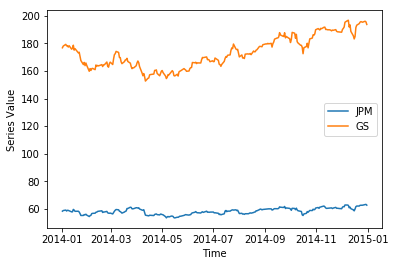

In [245]:
plt.plot(X1.index, X1.values)
plt.plot(X1.index, X2.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['JPM', 'GS']);

In [246]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()
results.params[1]

4.265344779079371

In [249]:
X1 = X1["Close Additive Returns"]

p-value = 0.012956431306316667 The series Z is likely non-stationary.


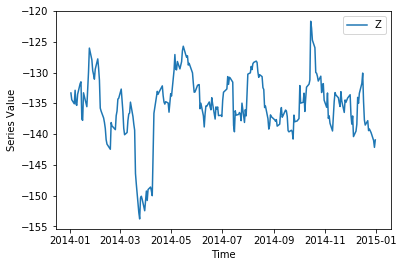

In [250]:
b = results.params[1]

Z = 0.65*X2 - b*X1 
Z.name = 'Z'

plt.plot(Z.index, Z.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([Z.name]);

check_for_stationarity(Z);

In [251]:
from statsmodels.tsa.stattools import coint

result_coint = coint(X1, X2)
result_coint

(-3.3167093488014006,
 0.052480328252696884,
 array([-3.94060523, -3.36058133, -3.06139039]))